# News text analysis

In [8]:
# import libraries
import numpy as np
import pandas as pd
import re
import seaborn as sns
import warnings

from datetime import datetime

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction import text

In [9]:
#from google.colab import drive
#drive.mount('/content/drive')

Dataset


## Auxiliary functions

In [10]:
def vectorize(corpus_full, corpus_data, min_df, max_df, gram_size):
    # vectorizes a corpus based on a given corpus vocabulary and returns tf, idf, tfidf total matrix
    np.seterr(divide='ignore', invalid='ignore')

    start_time = datetime.now()

    # Add custom stop words
    add_stopwords = ['000','like','pic','twitter','com','began', 'reuters', 'new', 'Reuters', 'york', 'times', 'image', 'screen', 'capture', 'video', 'getty', 'images', 'century', 'wire']
    stop_words = text.ENGLISH_STOP_WORDS.union(add_stopwords)

    # set parameters for vectorizer and fit full corpus demojized text
    cv = CountVectorizer(ngram_range = gram_size, stop_words=stop_words, min_df=min_df, max_df=max_df)
    tfidfv = TfidfVectorizer(ngram_range = gram_size, stop_words=stop_words, min_df=min_df, max_df=max_df)

    # fit and transform
    cv.fit(corpus_full.text)
    v_vc = cv.transform(corpus_data.text)
    tfidfv.fit(corpus_full.text)
    v_tfidf = tfidfv.transform(corpus_data.text)

    # densify and extract tf, idf, tfidf
    tf = np.array(v_vc.todense())
    idf = np.array(tfidfv.idf_)
    tfidf = np.array(v_tfidf.todense())

    # process count vectorizer
    rel_tf = tf/tf.sum(axis=1, keepdims=True) # relative frequency for each token per tweet (row)
    total_tf = tf.sum(axis=0) # sum of all frequencies for a particular token for all corpus (column)

    # process tfidf
    rel_tfidf = tfidf/tfidf.sum(axis=1, keepdims=True) # relative frequency for each token per tweet (row)
    total_tfidf = tfidf.sum(axis=0) # sum of all frequencies for a particular token for all corpus (column)

    print("tf matrix has size", tf.shape)
    print("idf idf matrix has size", idf.shape)
    print("tfidf matrix has size", tfidf.shape)

    end_time = datetime.now()
    print('Duration: {}'.format(end_time - start_time))
    return total_tf, rel_tf, idf, total_tfidf, rel_tfidf, cv

def cleanText(s):
    # finds and replaces multiple noisy characters from text
    # including emojis, hashtags and user mentions
    s = s.replace(r'<lb>', "\n")
    s = s.replace(r'<tab>', "\i")
    s = re.sub(r'<br */*>', "\n", s)
    s = s.replace("&lt;", "<").replace("&gt;", ">").replace("&amp;", "&")
    s = s.replace("&amp;", "&")
    s = s.replace(r'\n', ' ')
    s = re.sub(r"[^a-zA-Z -]", ' ', s)
    # markdown urls
    #s = re.sub(r'\(https*://[^\)]*\)', "[url]", s)
    s = re.sub(r'\(https*://[^\)]*\)', " ", s)
    # normal urls
    #s = re.sub(r'https*://[^\s]*', "[url]", s)
    s = re.sub(r"http?\S+", ' ', s)
    #s = re.sub(r'_+', ' ', s)
    s = re.sub(r'"+', '"', s)
    # custom removals
    #s = re.sub(r'@[A-Za-z0-9_]+', "@usermention", s) # remove mentions
    s = re.sub(r'@\S+', ' ', s)
    #s = re.sub(r'#[A-Za-z0-9_]+', "#hashtag", s) # remove hashtags
    s = re.sub(r'#[A-Za-z0-9_]+', " ", s) # remove hashtags
    #s = re.sub(r':[^:]+','[emoji]',s) # remove demojized text
    s = re.sub(r':[^:]+',' ',s)
    s = re.sub(r'\b\w{1,2}\b', '', s)
    return str(s)

def searchGrams(corpus_data, search_values):
    # searches a provided x-gram and on a set of text observations and returns the count of times found adding the x-term associated with them as an extra column
    search_results = pd.DataFrame()
    corpus_data_search = pd.DataFrame()
    pd.set_option('display.max_colwidth', None)
 
    for i in range(len(search_values)):
        search_results = corpus_data[corpus_data.text.str.contains('.*'.join(search_values_splitted[i]))]
        search_results['gram'] = search_values[i]
        print('Searching x-gram '+search_values[i]+' found '+ str(len(search_results)))
        corpus_data_search = corpus_data_search.append(search_results)
            
    return corpus_data_search

def string_to_date_true(string):
  date = datetime.strptime(string, "%B %d, %Y ")
  return date

def string_to_date_fake(string):
  date = datetime.strptime(string, "%d-%b-%y")
  return date


<>:46: SyntaxWarning: invalid escape sequence '\i'
<>:46: SyntaxWarning: invalid escape sequence '\i'
C:\Users\ivano\AppData\Local\Temp\ipykernel_84556\1091006244.py:46: SyntaxWarning: invalid escape sequence '\i'
  s = s.replace(r'<tab>', "\i")


## Load data

In [11]:
# load news files
docs_fake = pd.read_csv('./data/Fake.csv')
print(docs_fake.shape)
docs_true = pd.read_csv('./data/True.csv')
print(docs_true.shape)

#cleaning
docs_fake = docs_fake.drop(docs_fake.iloc[:, 4:],axis = 1)
docs_fake = docs_fake.dropna(axis = 0)
docs_fake["length"] = docs_fake.apply(lambda x : len(x["date"]), axis = 1)
docs_fake["length_subj"] = docs_fake.apply(lambda x : len(x["subject"]), axis = 1)
docs_fake = docs_fake.loc[docs_fake["length"] <=9]
docs_fake = docs_fake.loc[docs_fake["length_subj"] <= 20]
docs_fake['text'] = [cleanText(text) for text in docs_fake['text']]
docs_true['text'] = [cleanText(text) for text in docs_true['text']]
docs_true["date"] = docs_true.apply(lambda x : string_to_date_true(x["date"]), axis = 1)
docs_fake["date"] = docs_fake.apply(lambda x : string_to_date_fake(x["date"]), axis = 1)
docs_fake = docs_fake.loc[docs_fake["text"] != " "]
docs_true = docs_true.loc[docs_true["text"] != " "]

docs_fake['fake_flag'] = 1
docs_true['fake_flag'] = 0

docs_all = pd.concat([docs_fake, docs_true], axis=0)
docs_all.reset_index(inplace=True)
#print(docs_all.shape)

(23502, 4)
(21417, 4)


#Basic analysis for fake and true data sets

In [16]:
def vectorize(corpus_full, corpus_data, min_df, max_df, gram_size):
    # vectorizes a corpus based on a given corpus vocabulary and returns tf, idf, tfidf total matrix
    np.seterr(divide='ignore', invalid='ignore')

    start_time = datetime.now()

    # Add custom stop words
    add_stopwords = ['000','like','pic','twitter','com','began', 'reuters', 'new', 'Reuters', 'york', 'times', 'image', 'screen', 'capture', 'video', 'getty', 'images', 'century', 'wire', 'trump', 'president', 'united', 'states', 'washington', 'post']
    stop_words = text.ENGLISH_STOP_WORDS.union(add_stopwords)

    # set parameters for vectorizer and fit full corpus demojized text
    cv = CountVectorizer(ngram_range = gram_size, stop_words=list(stop_words), min_df=min_df, max_df=max_df)
    tfidfv = TfidfVectorizer(ngram_range = gram_size, stop_words=list(stop_words), min_df=min_df, max_df=max_df)

    # fit and transform
    cv.fit(corpus_full.text)
    v_vc = cv.transform(corpus_data.text)
    tfidfv.fit(corpus_full.text)
    v_tfidf = tfidfv.transform(corpus_data.text)

    # densify and extract tf, idf, tfidf
    tf = np.array(v_vc.todense())
    idf = np.array(tfidfv.idf_)
    tfidf = np.array(v_tfidf.todense())

    # process count vectorizer
    rel_tf = tf/tf.sum(axis=1, keepdims=True) # relative frequency for each token per tweet (row)
    total_tf = tf.sum(axis=0) # sum of all frequencies for a particular token for all corpus (column)

    # process tfidf
    rel_tfidf = tfidf/tfidf.sum(axis=1, keepdims=True) # relative frequency for each token per tweet (row)
    total_tfidf = tfidf.sum(axis=0) # sum of all frequencies for a particular token for all corpus (column)

    print("tf matrix has size", tf.shape)
    print("idf idf matrix has size", idf.shape)
    print("tfidf matrix has size", tfidf.shape)

    end_time = datetime.now()
    print('Duration: {}'.format(end_time - start_time))
    return total_tf, total_tfidf, cv

In [17]:
min_df = 100
max_df = 0.7
gram_size = (3,3)

total_tf_true, total_tfidf_true, cv_true = vectorize(docs_true, docs_true, min_df, max_df, gram_size)

tf matrix has size (21416, 302)
idf idf matrix has size (302,)
tfidf matrix has size (21416, 302)
Duration: 0:00:18.404278


In [19]:
freq_matrix_true = pd.DataFrame()
freq_matrix_true['term'] = cv_true.get_feature_names_out()
freq_matrix_true['tf'] = total_tf_true
freq_matrix_true['tfidf'] = total_tfidf_true
freq_matrix_true.sort_values(by = "tfidf", ascending = False)

,term,tf,tfidf
298,white house said,988,381.886274
178,prime minister theresa,584,371.541353
279,told news conference,495,289.444955
20,chancellor angela merkel,570,285.173419
209,russian vladimir putin,612,261.061839
...,...,...,...
127,libya somalia sudan,107,43.893825
27,clinton use private,126,43.115596
4,alleged russian meddling,107,42.644295
46,department spokeswoman heather,100,41.826166


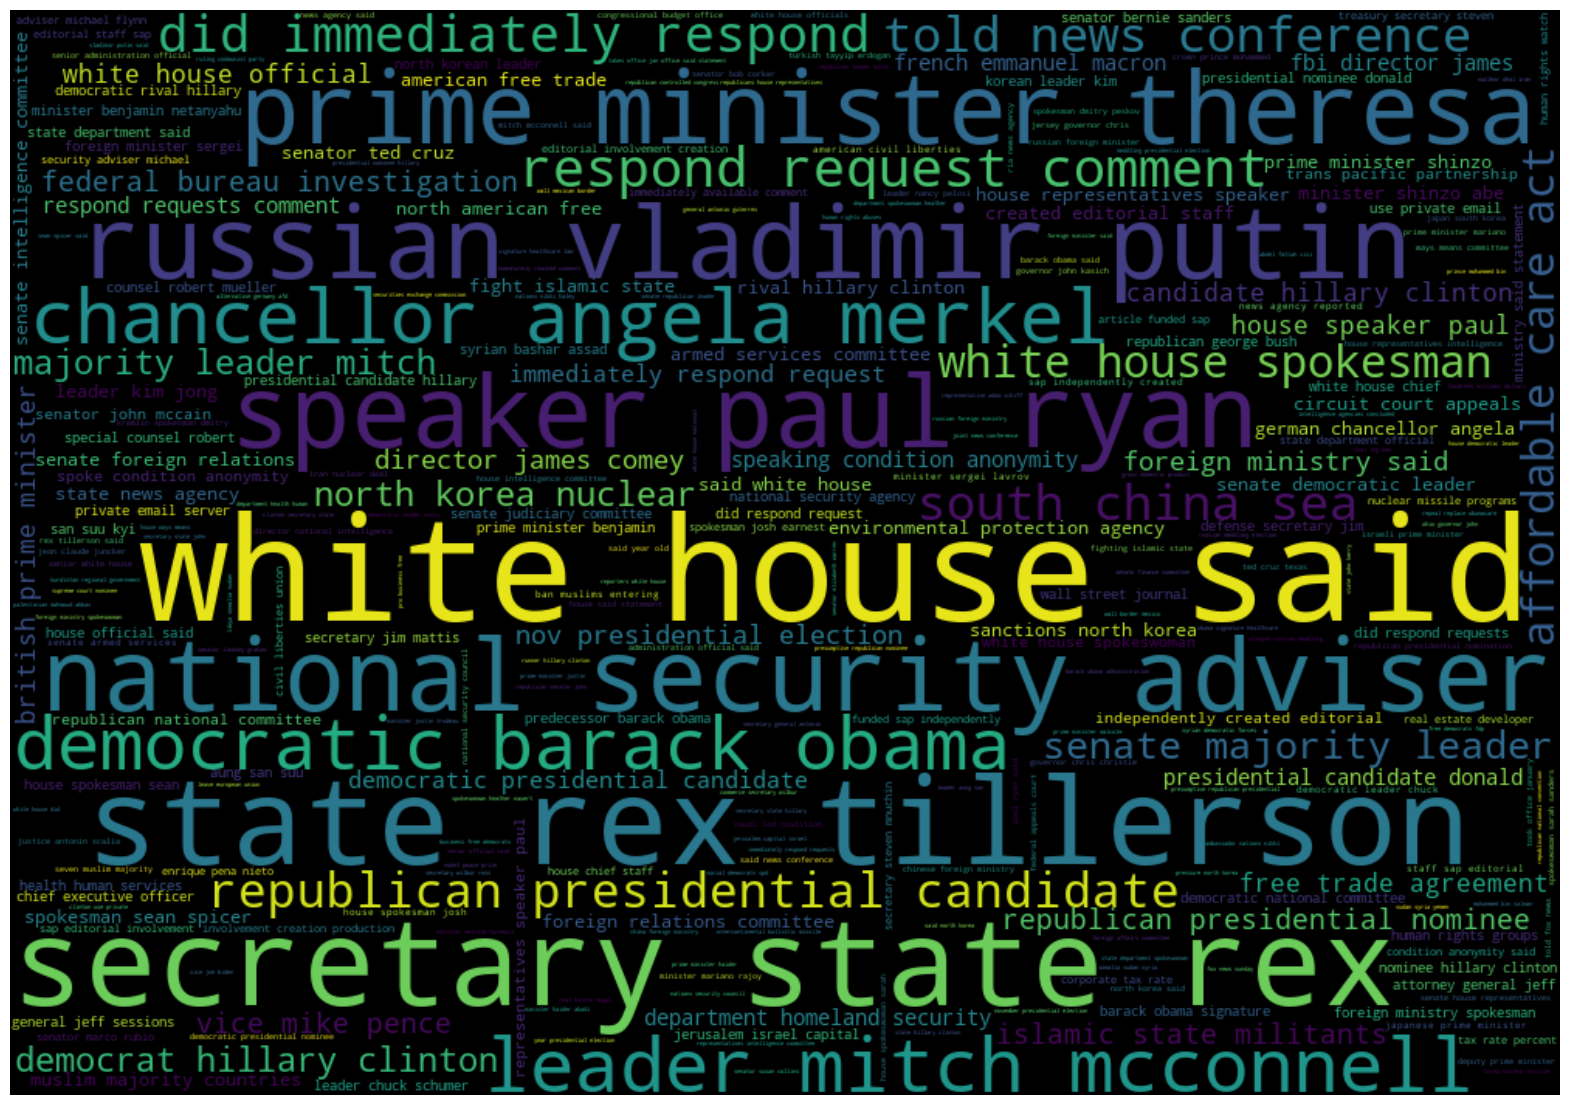

In [21]:
grams_dict_true = dict(zip(freq_matrix_true['term'].tolist(), freq_matrix_true['tf'].tolist()))
from wordcloud import WordCloud
wc = WordCloud(width=1000, height=700, max_words=300).generate_from_frequencies(grams_dict_true)
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 20))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

In [22]:
total_tf_fake, total_tfidf_fake, cv_fake = vectorize(docs_fake, docs_fake, min_df, max_df, gram_size)

tf matrix has size (22824, 155)
idf idf matrix has size (155,)
tfidf matrix has size (22824, 155)
Duration: 0:00:20.691507


In [24]:
freq_matrix_fake = pd.DataFrame()
freq_matrix_fake['term'] = cv_fake.get_feature_names_out()
freq_matrix_fake['tf'] = total_tf_fake
freq_matrix_fake['tfidf'] = total_tfidf_fake
freq_matrix_fake.sort_values(by = "tfidf", ascending = False)

,term,tf,tfidf
10,black lives matter,1304,590.499260
150,www youtube watch,573,418.808152
43,featured chip somodevilla,373,311.794670
80,make america great,403,278.339678
42,featured alex wong,301,241.171696
...,...,...,...
22,custom barfly philosophers,115,18.932456
116,room starting pst,113,18.619350
11,boiler room polictally,101,16.937934
115,room polictally correct,101,16.937934


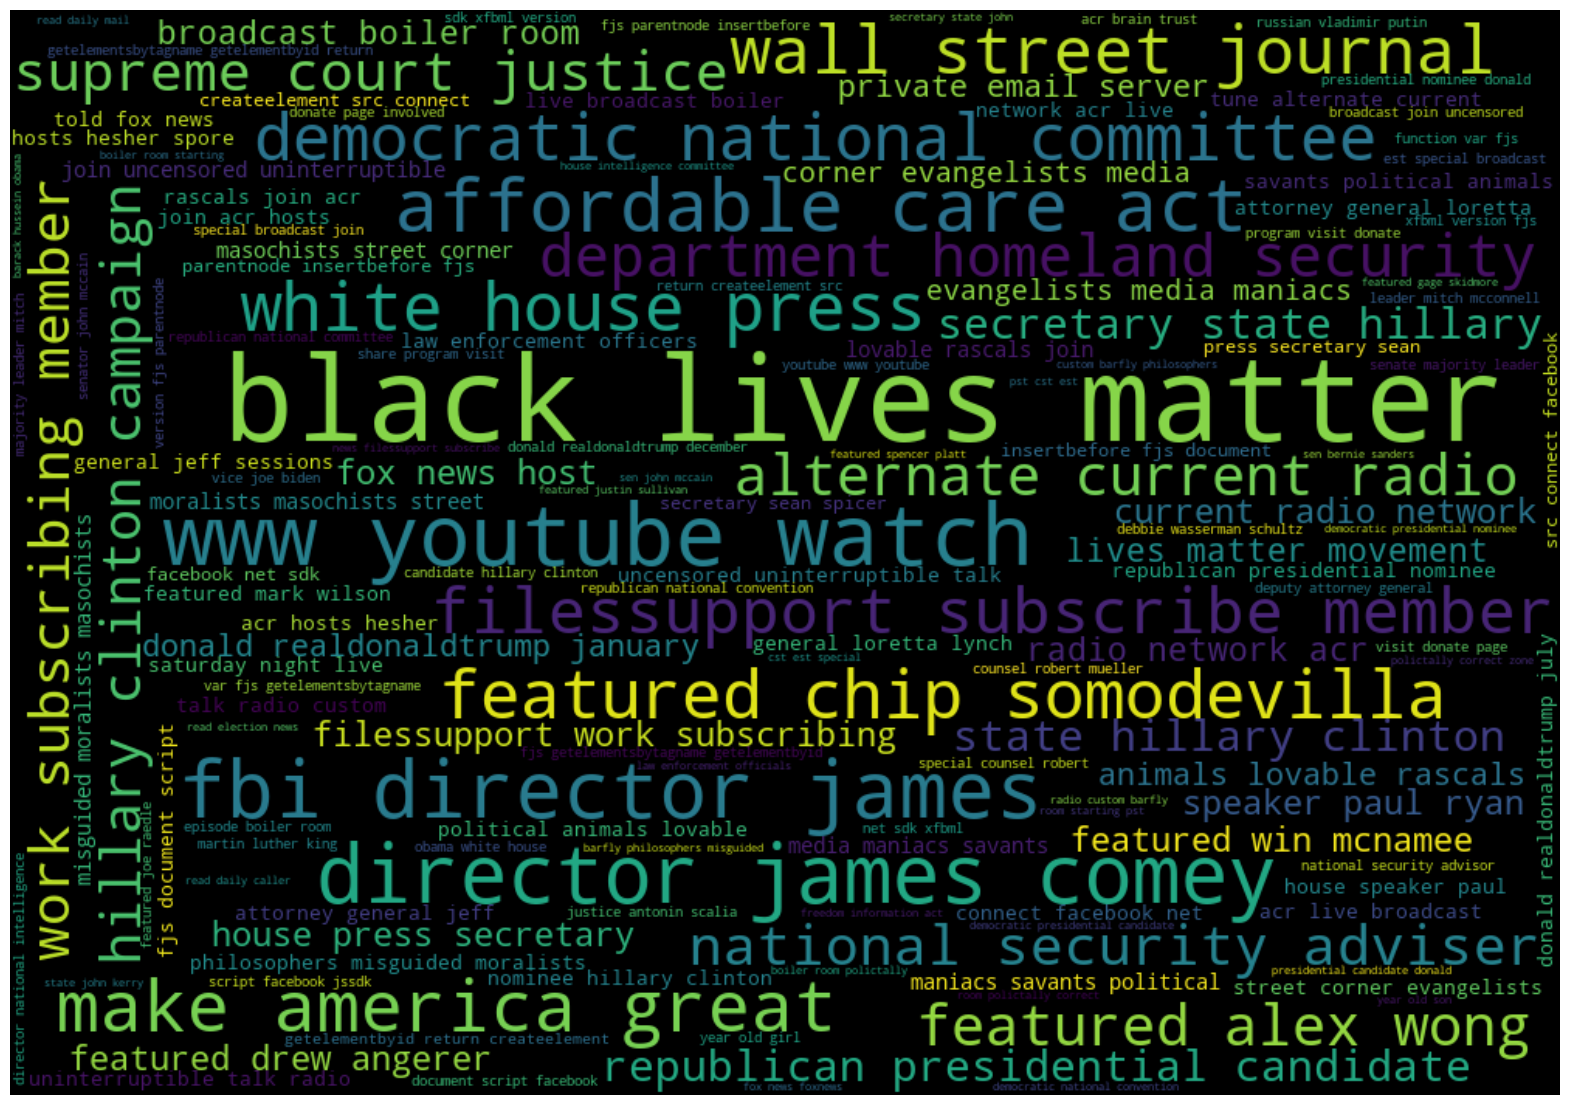

In [25]:
grams_dict_fake = dict(zip(freq_matrix_fake['term'].tolist(), freq_matrix_fake['tf'].tolist()))
from wordcloud import WordCloud
wc = WordCloud(width=1000, height=700, max_words=300).generate_from_frequencies(grams_dict_fake)
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 20))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

#Chi-squared (polarisation) statistic

In [28]:
min_df = 100
max_df = 0.7
gram_size = (2,3)

def vectorize(corpus_full, corpus_data, min_df, max_df, gram_size):
    # vectorizes a corpus based on a given corpus vocabulary and returns tf, idf, tfidf total matrix
    np.seterr(divide='ignore', invalid='ignore')

    start_time = datetime.now()

    # Add custom stop words
    add_stopwords = ['000','like','pic','twitter','com','began', 'reuters', 'new', 'Reuters', 'york', 'times', 'image', 'screen', 'capture', 'video', 'getty', 'images', 'century', 'wire', 'trump', 'president', 'united', 'states', 'washington', 'post', 'said']
    stop_words = text.ENGLISH_STOP_WORDS.union(add_stopwords)

    # set parameters for vectorizer and fit full corpus demojized text
    cv = CountVectorizer(ngram_range = gram_size, stop_words=list(stop_words), min_df=min_df, max_df=max_df)
    tfidfv = TfidfVectorizer(ngram_range = gram_size, stop_words=list(stop_words), min_df=min_df, max_df=max_df)

    # fit and transform
    cv.fit(corpus_full.text)
    v_vc = cv.transform(corpus_data.text)
    tfidfv.fit(corpus_full.text)
    v_tfidf = tfidfv.transform(corpus_data.text)

    # densify and extract tf, idf, tfidf
    tf = np.array(v_vc.todense())
    idf = np.array(tfidfv.idf_)
    tfidf = np.array(v_tfidf.todense())

    # process count vectorizer
    rel_tf = tf/tf.sum(axis=1, keepdims=True) # relative frequency for each token per tweet (row)
    total_tf = tf.sum(axis=0) # sum of all frequencies for a particular token for all corpus (column)

    # process tfidf
    rel_tfidf = tfidf/tfidf.sum(axis=1, keepdims=True) # relative frequency for each token per tweet (row)
    total_tfidf = tfidf.sum(axis=0) # sum of all frequencies for a particular token for all corpus (column)

    print("tf matrix has size", tf.shape)
    print("idf idf matrix has size", idf.shape)
    print("tfidf matrix has size", tfidf.shape)

    end_time = datetime.now()
    print('Duration: {}'.format(end_time - start_time))
    return total_tf, cv

In [29]:
sumcolumn_cv_true, cv = vectorize(docs_all, docs_true, min_df = min_df, max_df = max_df, gram_size = gram_size)

tf matrix has size (21416, 3153)
idf idf matrix has size (3153,)
tfidf matrix has size (21416, 3153)
Duration: 0:00:53.067092


In [30]:
sumcolumn_cv_fake, cv = vectorize(docs_all, docs_fake, min_df = min_df, max_df = max_df, gram_size = gram_size)

tf matrix has size (22824, 3153)
idf idf matrix has size (3153,)
tfidf matrix has size (22824, 3153)
Duration: 0:00:53.903946


In [32]:
#what follows is an implementation of the Gentzkow and Shapiro Xi squared statistic
#logic is very similar to the tfidf
tilda_true=sumcolumn_cv_true.sum()-sumcolumn_cv_true #number of tokens in true news that are not term v
tilda_fake=sumcolumn_cv_fake.sum()-sumcolumn_cv_fake
nominator=sumcolumn_cv_true*tilda_fake-sumcolumn_cv_fake*tilda_true
nominator=nominator*nominator
denominator=(sumcolumn_cv_true+sumcolumn_cv_fake)
denominator=denominator*(sumcolumn_cv_fake+tilda_true)
denominator=denominator*(sumcolumn_cv_true+tilda_fake)
denominator=denominator*(tilda_true+tilda_fake)
xi_squared=nominator/denominator
xi_squared=np.array([max(xi,0) for xi in xi_squared])
xi_sq_terms = dict(zip(cv.get_feature_names_out(), xi_squared.tolist()))
xi_sq_df = pd.DataFrame(list(xi_sq_terms.items()),columns = ['terms','xi_squared']) 

In [33]:
xi_sq_df['true_count'] = pd.Series(sumcolumn_cv_true)
xi_sq_df['fake_count'] = pd.Series(sumcolumn_cv_fake)
xi_sq_df['ratio'] = xi_sq_df['true_count']/(xi_sq_df['true_count'] + xi_sq_df['fake_count'])
xi_sq_df['bias'] = np.where(xi_sq_df['ratio']>0.5, "True", "Fake")

In [34]:
xi_sq_df.sort_values(by = ['xi_squared'], ascending=False).head(20)

,terms,xi_squared,true_count,fake_count,ratio,bias
1130,hillary clinton,1.385191,2499,7232,0.256808,Fake
1852,north korea,0.431598,5659,935,0.858204,True
1195,human rights,0.422297,2086,674,0.755797,True
1562,mainstream media,0.309883,26,1205,0.021121,Fake
2924,told reporters,0.297899,3178,317,0.909299,True
2139,prime minister,0.264741,4163,579,0.877900,True
644,didn want,0.264339,41,265,0.133987,Fake
873,featured screenshot,0.230732,0,820,0.000000,Fake
2310,republican party,0.211388,739,1514,0.328007,Fake
2932,town hall,0.194058,158,352,0.309804,Fake


<Axes: xlabel='terms'>

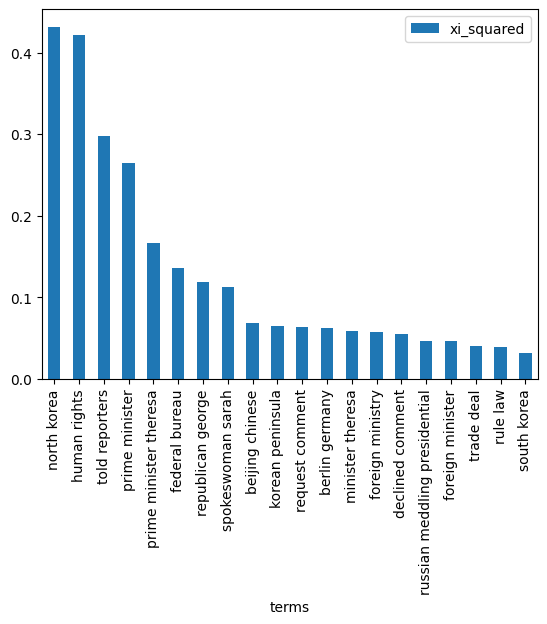

In [35]:
import matplotlib.pyplot as plt
xi_sq_df.loc[xi_sq_df["bias"] == "True"].nlargest(20, 'xi_squared').plot.bar("terms", "xi_squared")

<Axes: xlabel='terms'>

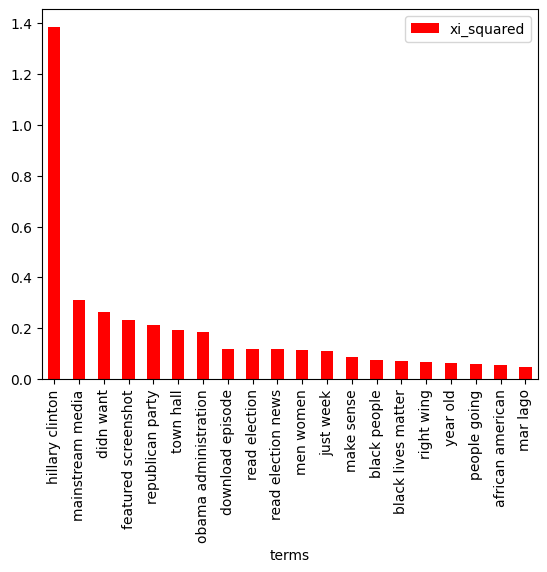

In [36]:
xi_sq_df.loc[xi_sq_df["bias"] == "Fake"].nlargest(20, 'xi_squared').plot.bar("terms", "xi_squared", color = "red")

##Observe polarisation over time 

In [37]:
docs_all = docs_all.loc[docs_all["date"] <= max(docs_all.loc[docs_all["fake_flag"] == 0]["date"])]
docs_all = docs_all.loc[docs_all["date"] >= min(docs_all.loc[docs_all["fake_flag"] == 0]["date"])]
docs_all["month_year"] = docs_all.apply(lambda x : (x["date"].strftime('%Y-%m')), axis = 1)

In [38]:
def basic_matrix_cv_relative(cv_trained, corpus):
    vectorized_text=cv_trained.transform(corpus)
    vectorized_text=vectorized_text.todense()
    
    dt_matrix_cv=np.array(vectorized_text)
    rel_dt_matrix_cv=dt_matrix_cv/dt_matrix_cv.sum(axis=1, keepdims=True)
    
    return rel_dt_matrix_cv

In [40]:
#here I am fitting to the whole dataset
dt_matrix_rel = basic_matrix_cv_relative(cv, docs_all.text)
#multiplying the xi squared score for each word in the term across all documents
xi_sq_matrix = dt_matrix_rel * xi_sq_df["xi_squared"].to_numpy()[:, np.newaxis].T
#summing to give a xi_squared (polarization) score per document
xi_sq_doc = xi_sq_matrix.sum(axis = 1)

In [41]:
import statistics
#now calculating this per month
months = docs_all['month_year']
t=np.unique(months)

timeline=[]
pol_score=[]

for time in t:
    timeline.append(time)
    ids = np.where(months==time)
    #do element wise multiplication to the whole dataset (each element in each row is multiplied by chi-squared statistic)
    #then get the id's per month and fake flag of the dataset (document ids)
    #then calculate the sum of the multiplied tf matrix
    pol_score.append(np.nanmean(xi_sq_doc[ids]))
    

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23],
 [Text(0, 0, '2016-01'),
  Text(1, 0, '2016-02'),
  Text(2, 0, '2016-03'),
  Text(3, 0, '2016-04'),
  Text(4, 0, '2016-05'),
  Text(5, 0, '2016-06'),
  Text(6, 0, '2016-07'),
  Text(7, 0, '2016-08'),
  Text(8, 0, '2016-09'),
  Text(9, 0, '2016-10'),
  Text(10, 0, '2016-11'),
  Text(11, 0, '2016-12'),
  Text(12, 0, '2017-01'),
  Text(13, 0, '2017-02'),
  Text(14, 0, '2017-03'),
  Text(15, 0, '2017-04'),
  Text(16, 0, '2017-05'),
  Text(17, 0, '2017-06'),
  Text(18, 0, '2017-07'),
  Text(19, 0, '2017-08'),
  Text(20, 0, '2017-09'),
  Text(21, 0, '2017-10'),
  Text(22, 0, '2017-11'),
  Text(23, 0, '2017-12')])

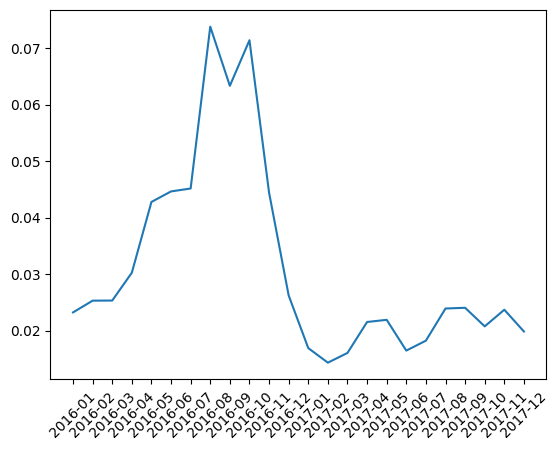

In [42]:
#plot results 
pol_df = pd.DataFrame()
pol_df["date"] = timeline
pol_df["score"] = pol_score
plt.plot(pol_df.date, pol_df.score)
plt.xticks(rotation = 45)

# Other metrics
##Calculating average length of article 

In [44]:
# set parameters for vectorizer and fit full corpus demojized text
min_df = 50
gram_size = (1,1)

# Add custom stop words
add_stopwords = ['like','pic','twitter','com', 'Reuters', 'getty', 'images', 'reuters']
stop_words = text.ENGLISH_STOP_WORDS.union(add_stopwords)

def basic_matrix_cv(cv_trained, corpus):
    vectorized_text=cv_trained.transform(corpus)
    dt_matrix_cv=np.array(vectorized_text.todense())
    return dt_matrix_cv

  
#true
cv_true = CountVectorizer(ngram_range = gram_size, stop_words=list(stop_words), min_df = min_df)
cv_true.fit(docs_true.text)
dt_matrix_true_2 = basic_matrix_cv(cv_true, docs_true.text)

#fake
cv_false = CountVectorizer(ngram_range = gram_size, stop_words=list(stop_words), min_df = min_df)
cv_false.fit(docs_fake.text)
dt_matrix_fake_2 = basic_matrix_cv(cv_false, docs_fake.text)


In [45]:
words_per_doc_true = dt_matrix_true_2.sum(axis = 0)
words_per_doc_fake = dt_matrix_fake_2.sum(axis = 0)


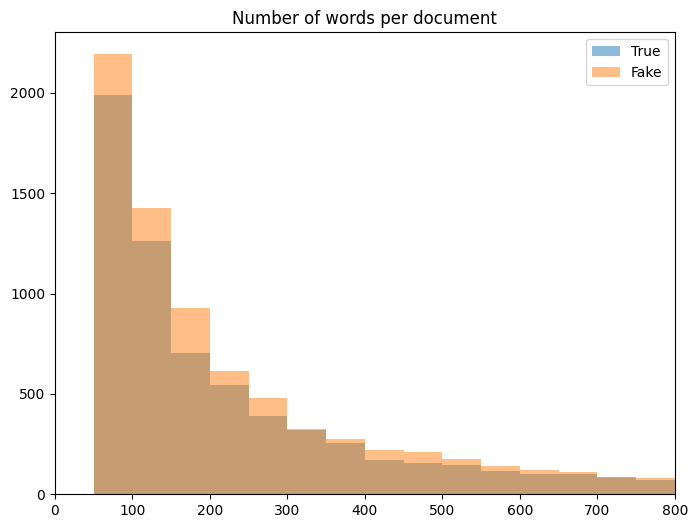

In [46]:
import matplotlib.pyplot as plt
width = 50
plt.figure(figsize=(8,6))
plt.hist(words_per_doc_true, bins = np.arange(0, 800 + width, width), alpha=0.5, label="True")
plt.hist(words_per_doc_fake, bins = np.arange(0, 800 + width, width), alpha=0.5, label="Fake")
plt.xlim(0,800)
plt.title("Number of words per document")
plt.legend(loc='upper right')

##Calculate average number of different words, normalised by the article length

In [47]:
unique_words_per_doc_true = (np.count_nonzero(dt_matrix_true_2,axis = 0))/words_per_doc_true
unique_words_per_doc_fake = (np.count_nonzero(dt_matrix_fake_2,axis = 0))/words_per_doc_fake

In [48]:
unique_words_per_doc_fake

array([0.78453039, 0.89922481, 0.90384615, ..., 0.74348697, 0.655     ,
       0.40136054], shape=(8557,))

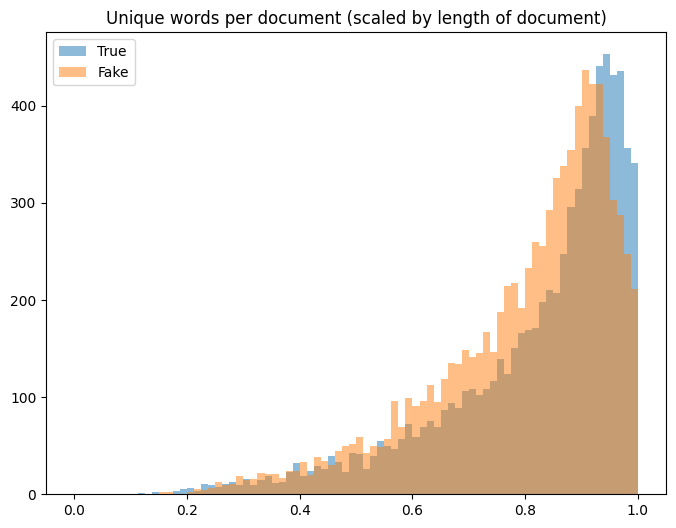

In [49]:
width = 0.0125
plt.figure(figsize=(8,6))
plt.hist(unique_words_per_doc_true, bins = np.arange(0, 1 + width, width), alpha=0.5, label="True")
plt.hist(unique_words_per_doc_fake, bins = np.arange(0, 1 + width, width), alpha=0.5, label="Fake")
plt.title("Unique words per document (scaled by length of document)")
plt.legend(loc='upper left')

##Calculate amount of capital letters in title 

In [50]:
def capitals(string):
  caps = len(re.findall(r'[A-Z]',string))
  all = (len(re.findall(r'[A-Za-z]', string))) +1
  return caps/all 

docs_true["caps_title"] = docs_true.apply(lambda x : capitals(x["title"]), axis = 1)
docs_fake["caps_title"] = docs_fake.apply(lambda x : capitals(x["title"]), axis = 1)

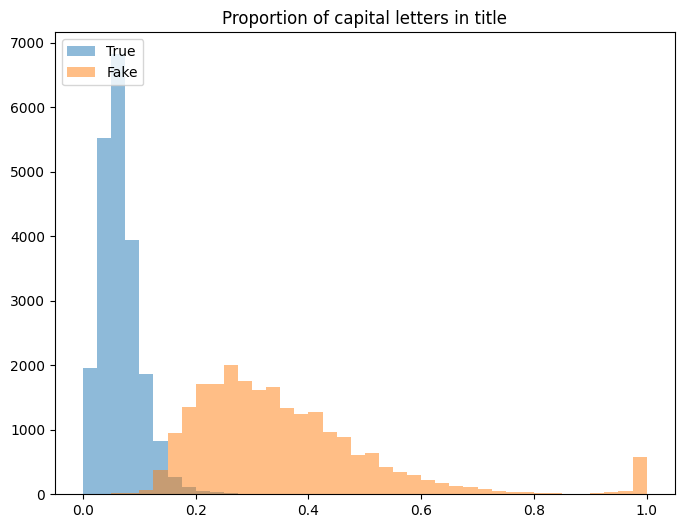

In [51]:
width = 0.025
plt.figure(figsize=(8,6))
plt.hist(docs_true["caps_title"], bins = np.arange(0, 1 + width, width), alpha=0.5, label="True")
plt.hist(docs_fake["caps_title"], bins = np.arange(0, 1 + width, width), alpha=0.5, label="Fake")
plt.title("Proportion of capital letters in title")
plt.legend(loc='upper left')